# Progetto d'esame per il corso Laboratorio di Software per le telecomunicazioni
_Andrea Argnani_
a.a. 2023/2024

## Traccia d'esame:
_In questo progetto, viene fornito il dataset housing.csv, in cui sono riportate le coordinate, numero di stanze, di camere da letto, abitanti e altre informazioni su delle abitazioni in California (per zona). L’obiettivo del progetto è quello di predire il valore medio dell’abitazione (median_house_value) con determinate caratteristiche._

## Importazione librerie:

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
import numpy.random as rnd

Imposto un random seed per avere risultati ripetibili:

In [72]:
RS = 24
rnd.seed(RS)

## Importazione dataset

In [106]:
df = pd.read_csv('housing.csv')
df.head(6)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


# Data preprocessing:
Si controlla se ci sono dati mancanti:

In [74]:
for column in df.columns:
    n_missing = df[column].isnull().sum()
    print(f"{column} -> {n_missing} missing values")

longitude -> 0 missing values
latitude -> 0 missing values
housing_median_age -> 0 missing values
total_rooms -> 0 missing values
total_bedrooms -> 207 missing values
population -> 0 missing values
households -> 0 missing values
median_income -> 0 missing values
median_house_value -> 0 missing values
ocean_proximity -> 0 missing values


L' unica colonna con dati mancanti è _total_bedrooms_. Si può ipotizzare che il numero di camere da letto sia proporzionale al numero di stanze, quindi si può calcolare il rapporto tra camere da letto e stanze e moltiplicarlo per il numero di stanze per ottenere il numero di camere da letto dove il dato manca.
Si verifica questa ipotesi calcolando la correlazione tra le due variabili:

Correlazione: 0.9303795046865079


<Axes: xlabel='total_rooms', ylabel='total_bedrooms'>

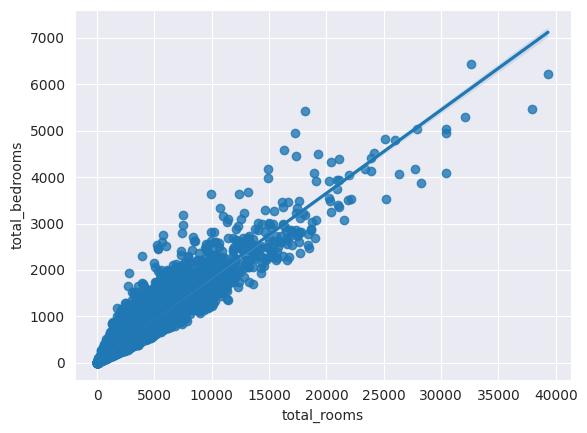

In [75]:
print(f"Correlazione: {df['total_bedrooms'].corr(df['total_rooms'])}")
sns.regplot(x='total_rooms', y='total_bedrooms', data=df)

La correlazione è molto alta (0.93), per cui si procede a sostituire i valori mancanti con il valore calcolato:

In [76]:
df_p = df.dropna(subset=['total_bedrooms'])
BoR = df_p['total_bedrooms'] / df_p['total_rooms']
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_rooms'] * BoR.mean())

### Ricerca di misspelling nelle variabili non numeriche:

In [77]:
print(df['ocean_proximity'].unique())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


L' unica variabile non numerica è _ocean_proximity_ e non contiene misspelling.

### Ricerca di outlier

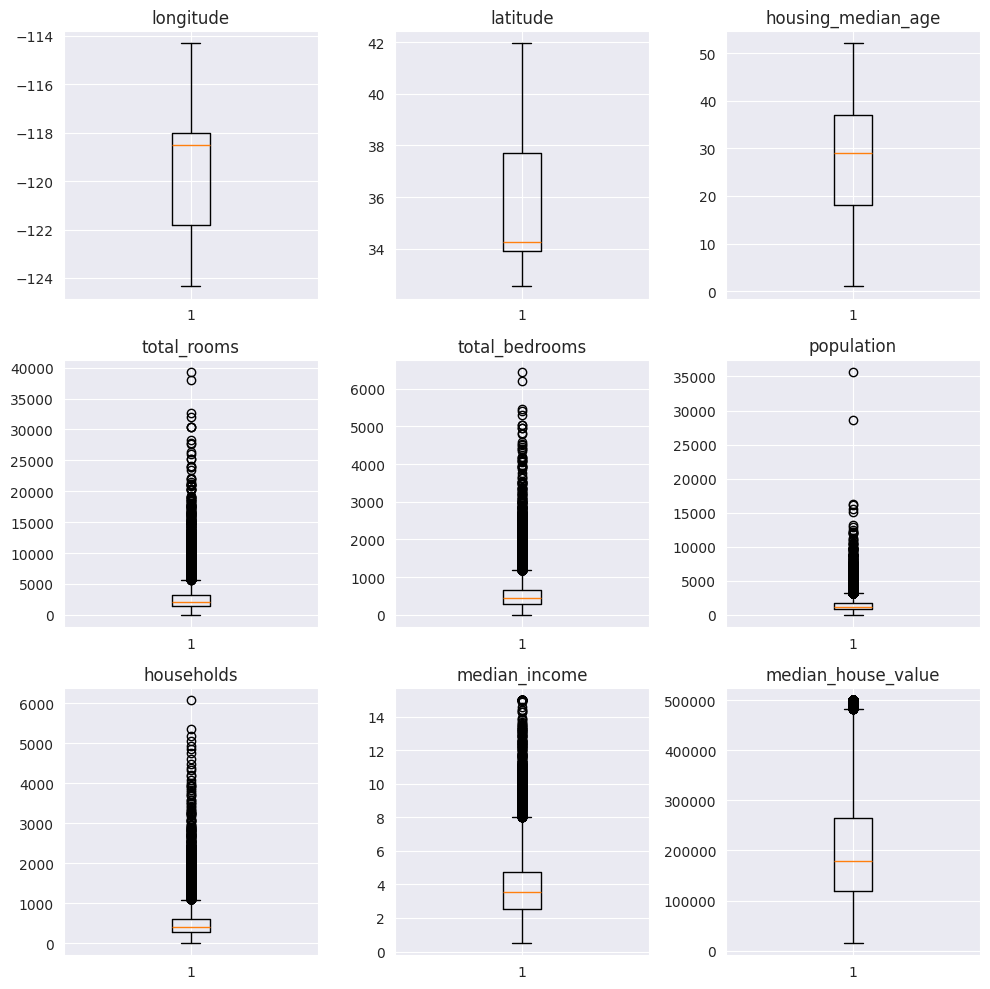

In [78]:
df_noOp = df.drop(columns=['ocean_proximity'])
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, column in enumerate(df_noOp.columns):
    axis[i//3, i%3].boxplot(df_noOp[column])
    axis[i//3, i%3].set_title(column)
plt.tight_layout()
plt.show()

Ci sono molti valori che superano il baffo superiore del boxplot, ma non si considerano come outlier perché sono dovuti alla distribuzione dei dati molto concentrata attorno al valore medio.
Di seguito la distribuzione dei dati:

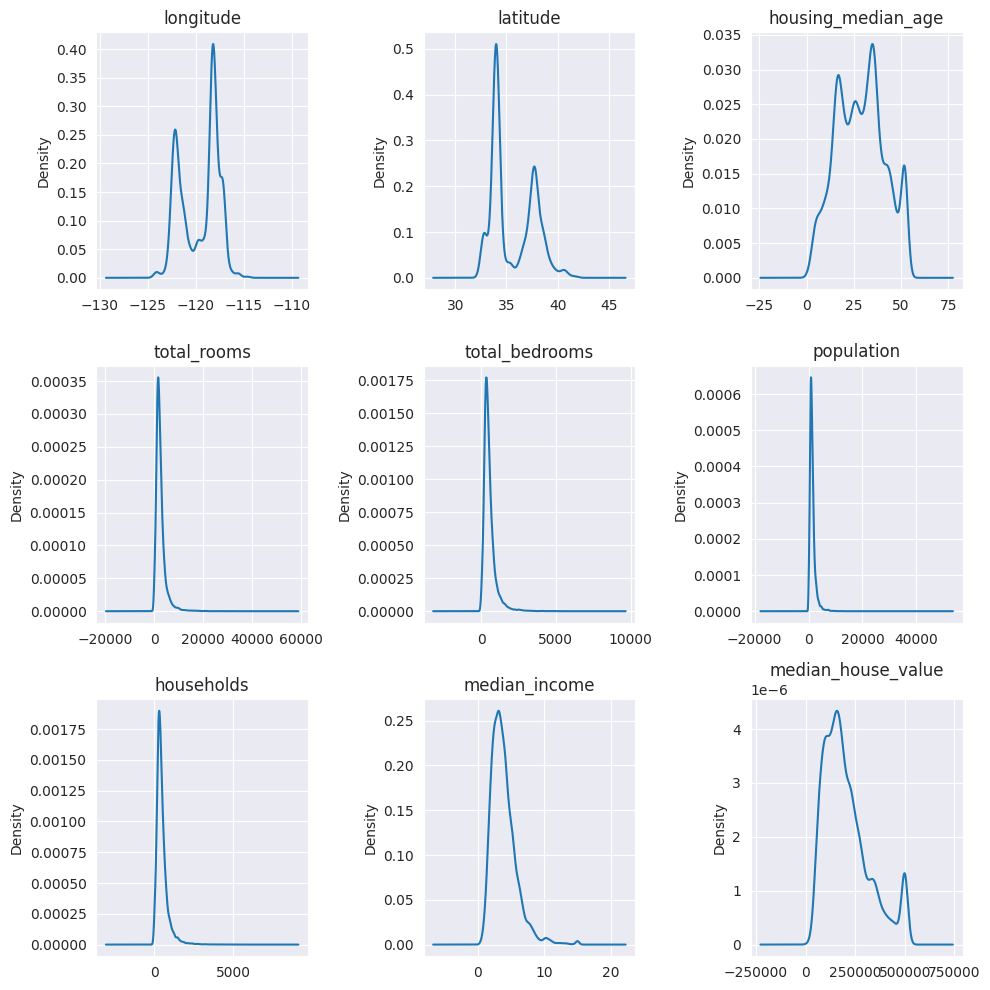

In [79]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, column in enumerate(df_noOp.columns):
    ax = axis[i//3, i%3]
    df_noOp[column].plot(kind='kde', ax=ax, x='auto')
    ax.set_title(column)
plt.tight_layout()
plt.show()

## Data format
Si convertono i valori di _ocean_proximity_ in valori numerici con il metodo _get_dummies_

In [107]:
print("Prima della conversione:")
print(df.dtypes)
df = pd.get_dummies(data=df, columns=['ocean_proximity'], drop_first=False)
print("\nDopo la conversione:")
print(df.dtypes)
df.head(6)

Prima della conversione:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Dopo la conversione:
longitude                     float64
latitude                      float64
housing_median_age            float64
total_rooms                   float64
total_bedrooms                float64
population                    float64
households                    float64
median_income                 float64
median_house_value            float64
ocean_proximity_<1H OCEAN        bool
ocean_proximity_INLAND           bool
ocean_proximity_ISLAND           bool
ocean_proximity_NEAR BAY         bool
ocean_proximity_NEAR OCEAN       bool
dtype: object


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,False,False,False,True,False


# Regressione lineare semplice
Come primo approccio si prova una regressione lineare semplice, scegliendo la variabile con la più alta correlazione:

In [81]:
for i, col in enumerate(df.columns):
    if col != 'median_house_value':
        print(f"Correlazione tra prezzo e {col}: {df['median_house_value'].corr(df[col])}")

Correlazione tra prezzo e longitude: -0.04596661511797843
Correlazione tra prezzo e latitude: -0.14416027687465927
Correlazione tra prezzo e housing_median_age: 0.10562341249320994
Correlazione tra prezzo e total_rooms: 0.13415311380656306
Correlazione tra prezzo e total_bedrooms: 0.051376529738816214
Correlazione tra prezzo e population: -0.02464967888889488
Correlazione tra prezzo e households: 0.06584265057005646
Correlazione tra prezzo e median_income: 0.6880752079585477
Correlazione tra prezzo e ocean_proximity_<1H OCEAN: 0.25661683623001535
Correlazione tra prezzo e ocean_proximity_INLAND: -0.48485933464866887
Correlazione tra prezzo e ocean_proximity_ISLAND: 0.023416076436869285
Correlazione tra prezzo e ocean_proximity_NEAR BAY: 0.16028448367166812
Correlazione tra prezzo e ocean_proximity_NEAR OCEAN: 0.14186216979619454


La variabile con la più alta correlazione è _median_income_. Questo il suo grafico di correlazione:

<Axes: xlabel='median_income', ylabel='median_house_value'>

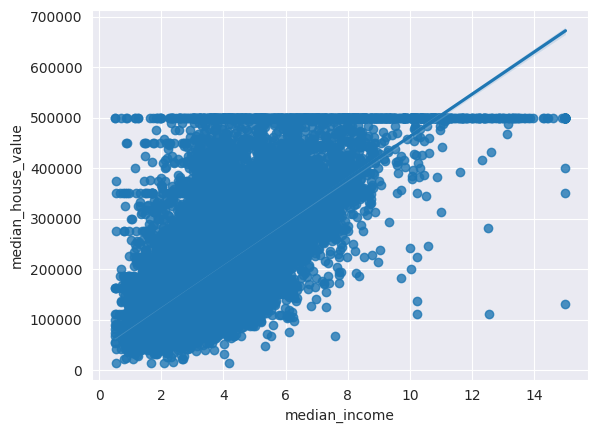

In [82]:
sns.regplot(x='median_income', y='median_house_value', data=df)

### Train test split

In [83]:
df_reg = df[['median_income', 'median_house_value']]
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RS)

### Calcolo regressione lineare con holdout validation:

In [84]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

y_hat = regressor.predict(X_test)

### Prestazioni del modello
Si definisce una funzione che stampi i valori utili a valutare le prestazioni del modello:

In [85]:
def prestazioni(y_hat_p, Y_test_p, n_feature):
    mse = np.mean((y_hat_p - Y_test_p)**2)
    mae = np.mean(np.abs(y_hat_p - Y_test_p))
    print(f"MSE: {mse}")
    print(f"Root MSE: {np.sqrt(mse)}")
    print(f"MAE: {mae}")
    print(f"R2 score {r2_score(Y_test_p, y_hat_p)}")
    print(f"Adj. R2 score {adj_r2_score(Y_test_p, y_hat_p, n_feature)}")
    
def adj_r2_score(y_true, y_pred, n_features):
    return 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - n_features - 1)

results = []

In [86]:
prestazioni(y_hat, Y_test, 1)
results.append({"tipo":"Semplice", "n_feature":1, "validation":"Holdout", "r2":r2_score(Y_test, y_hat), "adj_r2":adj_r2_score(Y_test, y_hat, 1)})

MSE: 6744576854.437529
Root MSE: 82125.37278111758
MAE: 61634.123079362456
R2 score 0.49099848976352456
Adj. R2 score 0.4908751253645337


Si è ottenuto un R2 score di **0.490**, che non è un buon risultato, ma è comunque un buon punto di partenza.

## Con k-fold cross validation
Iteriamo con diversi valori di n_fold per trovare il valore migliore:

In [87]:
r2_scores = []
n_folds = [2, 3, 4, 5, 10, 50,  100, 200, 500, 1000]
print("n_fold:\t\t\tR2 score:")
for n_fold in n_folds:
    kf = KFold(n_splits=n_fold, random_state=42, shuffle=True)
    regressor = LinearRegression()
    y_hat = cross_val_predict(regressor, X, Y, cv=kf)
    r2_scores.append([n_fold, r2_score(Y, y_hat), adj_r2_score(Y, y_hat, 1)])
    print(f"{n_fold}\t\t{r2_score(Y, y_hat)}\t\t{adj_r2_score(Y, y_hat, 1)}")

r2_scores = np.array(r2_scores)

n_fold:			R2 score:
2		0.47341305867086725		0.47338754326524024
3		0.4734025943288912		0.4733770784162219
4		0.4734240691207602		0.47339855424863686
5		0.473386398946553		0.47336088224914763
10		0.47333428543827527		0.4733087662157458
50		0.4733243847698352		0.4732988650675758
100		0.4733228450184337		0.47329732524156665
200		0.47334016710496196		0.47331464816742463
500		0.47333063933567365		0.47330511993647484
1000		0.4733247816981955		0.4732992620151689


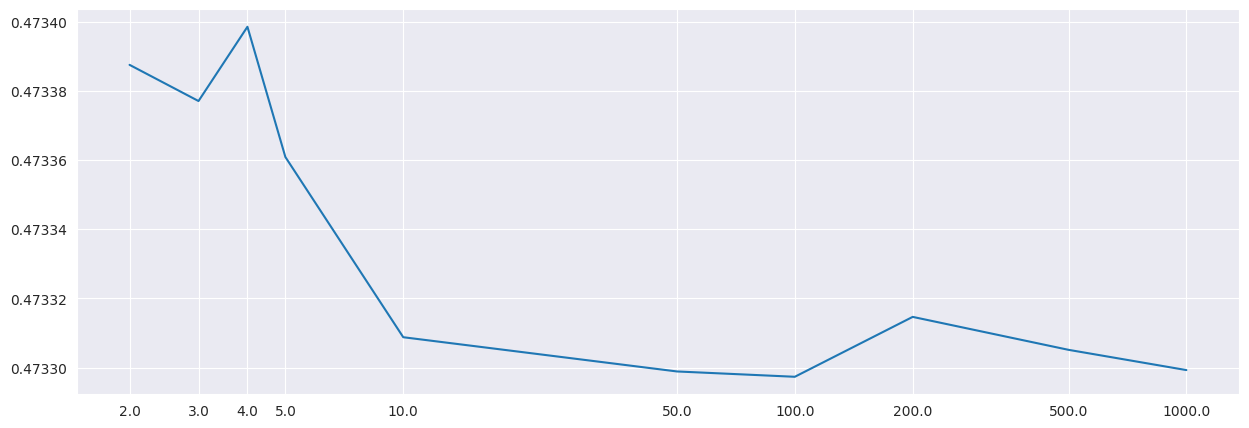

In [88]:
plt.figure(figsize=(15, 5))
plt.semilogx(r2_scores[:, 0], r2_scores[:, 2])
plt.xticks(r2_scores[:, 0], r2_scores[:, 0])
plt.show()

Con n_fold=4 si ottiene il miglior risultato, con un adj. R2 score di **0.473**, che è però peggiore rispetto al risultato ottenuto con holdout validation.

In [89]:
n_fold = 4
kf = KFold(n_splits=n_fold, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, 1)
results.append({"tipo":"Semplice", "n_feature":1, "validation":"K-fold (n_fold=4)", "r2":r2_score(Y, y_hat), "adj_r2":adj_r2_score(Y, y_hat, 1)})

MSE: 7015826844.06852
Root MSE: 83760.53273510454
MAE: 62648.77465395596
R2 score 0.4731083877464125
Adj. R2 score 0.4730828575781668


# Regressione lineare multipla

### Senza feature selection con holdout validation

In [90]:
X = df.drop(columns=['median_house_value'])
Y = df['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RS)

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))
results.append({"tipo":"Multipla con tutte le feature", "n_feature":len(X.columns), "validation":"Holdout", "r2":r2_score(Y_test, y_hat), "adj_r2":adj_r2_score(Y_test, y_hat, len(X.columns))})

MSE: 4530943903.884664
Root MSE: 67312.2864259168
MAE: 49424.954481699584
R2 score 0.6580575268622426
Adj. R2 score 0.6569770085951568


Si ottiene un ottimo risultato con un adjusted R2 score di **0.656**.

### Senza feature selection, con k-fold cross validation

In [91]:
n_fold = 4
kf = KFold(n_splits=n_fold, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, len(X.columns))
results.append({"tipo":"Multipla con tutte le feature", "n_feature":len(X.columns), "validation":"K-fold (n_fold=4)", "r2":r2_score(Y, y_hat), "adj_r2":adj_r2_score(Y, y_hat, len(X.columns))})

MSE: 4729096246.747183
Root MSE: 68768.42478017934
MAE: 49815.78097495581
R2 score 0.6448428387229054
Adj. R2 score 0.6446189929410475


Si ottiene un adjusted R2 score di **0.644**, che è un buon risultato ma ancora una volta peggiore rispetto a quello ottenuto con holdout validation.

## Con feature selection
Si prendono le feature con correlazione maggiore rispetto a _median_house_value_

In [92]:
df_reg = df[['latitude', 'median_income', 'ocean_proximity_<1H OCEAN','ocean_proximity_INLAND', 'median_house_value']]
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']

n_fold = 4
kf = KFold(n_splits=n_fold, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, len(X.columns))
results.append({"tipo":"Multipla con feature selection", "n_feature":len(X.columns), "validation":"K-fold (n_fold=4)", "r2":r2_score(Y, y_hat), "adj_r2":adj_r2_score(Y, y_hat, len(X.columns))})

MSE: 5499402045.282042
Root MSE: 74157.95335149186
MAE: 53735.581854564174
R2 score 0.5869925420808986
Adj. R2 score 0.5869124824815928


In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))
results.append({"tipo":"Multipla con feature selection", "n_feature":len(X.columns), "validation":"Holdout", "r2":r2_score(Y_test, y_hat), "adj_r2":adj_r2_score(Y_test, y_hat, len(X.columns))})

MSE: 5276775480.328873
Root MSE: 72641.41711399134
MAE: 53217.692842513534
R2 score 0.6017709121515835
Adj. R2 score 0.601384563291192


I risultati ottenuti sono peggiori, perciò conviene utilizzare tutte le feature.

# Rimozione valore limite
Dal grafico seguente si nota che il dato _median_house_value_ è stato limitato superiormente al valore 500000 e ciò potrebbe influenzare i risultati.
Si prova a rimuovere (solo dal train set) i dati con _median_house_value_ = 500000 e si verifica se i risultati migliorano.

<Axes: xlabel='median_income', ylabel='median_house_value'>

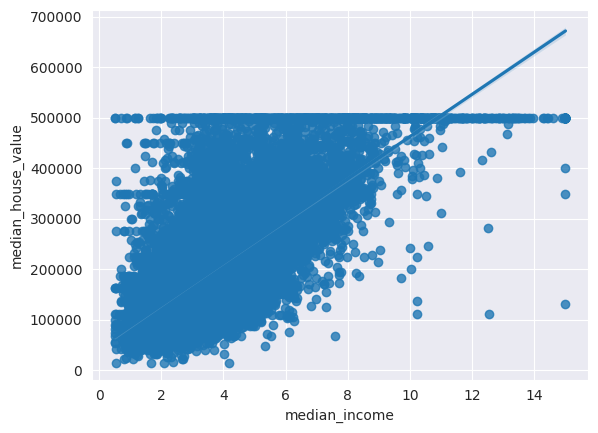

In [94]:
sns.regplot(x='median_income', y='median_house_value', data=df)

<Axes: xlabel='median_income', ylabel='median_house_value'>

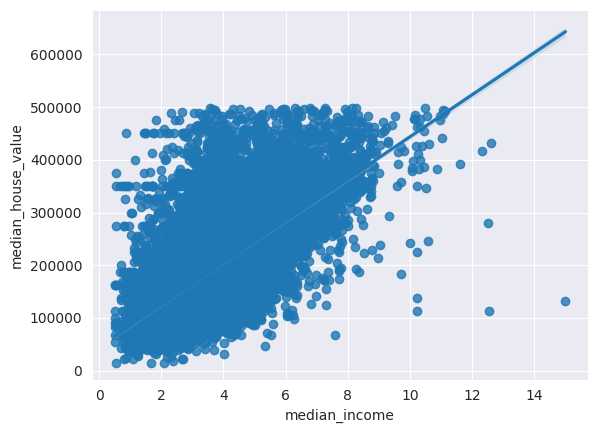

In [95]:
df_reg = df.copy(deep=True)
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

df_train = pd.concat([X_train, Y_train], axis=1)
df_train = df_train[df_train['median_house_value'] < 500000]
X_train = df_train.drop(columns=['median_house_value'])
Y_train = df_train['median_house_value']

sns.regplot(x='median_income', y='median_house_value', data=df_train)

In [96]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))
results.append({"tipo":"Multipla con rimozione outlier", "n_feature":len(X.columns), "validation":"Holdout", "r2":r2_score(Y_test, y_hat), "adj_r2":adj_r2_score(Y_test, y_hat, len(X.columns))})

MSE: 5098969840.081652
Root MSE: 71407.07135908636
MAE: 50582.02435731861
R2 score 0.6305636727573232
Adj. R2 score 0.6293962755151854


Si ottengono dei buoni risultati, ma non migliori rispetto a quelli ottenuti senza rimuovere questi dati.

# Nuovo approccio

Dalla mappa dei prezzi della California si nota che i prezzi sono più alti vicino alle grandi città, come San Francisco e Los Angeles.
(La funzione per il grafico è stata presa da <a href="https://medium.com/mlearning-ai/implementing-linear-regression-on-california-housing-dataset-378e14e421b7">qui</a>)

<Axes: xlabel='longitude', ylabel='latitude'>

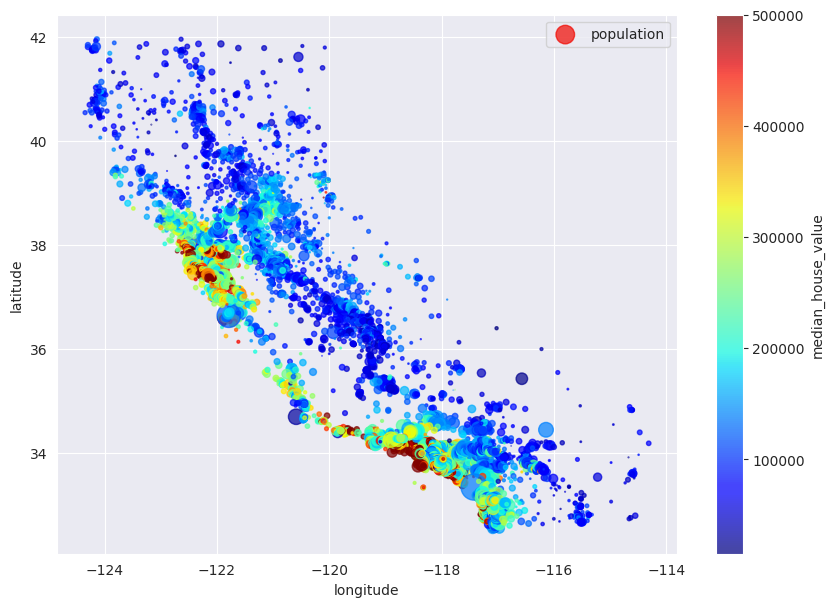

In [97]:
df.plot(kind="scatter", x="longitude",y="latitude", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7), s=df['population']/100, label="population", alpha=0.7)

Per tanto può essere utile aggiungere una feature, _distance_from_big_city_, che indichi la distanza da una grande città, calcolata come il minimo tra la distanza da San Francisco e da Los Angeles, e quindi introducendo una non linearità nel nostro modello.

In [98]:
san_francisco_coord = [-122.4194, 37.7749]
los_angeles_coord = [-118.2437, 34.0522]

In [99]:
df_new = df.copy(deep=True)
df_new['distance_from_SF'] = np.sqrt((df['longitude'] - san_francisco_coord[0])**2 + (df['latitude'] - san_francisco_coord[1])**2)
df_new['distance_from_LA'] = np.sqrt((df['longitude'] - los_angeles_coord[0])**2 + (df['latitude'] - los_angeles_coord[1])**2)
df_new['distance_from_big_city'] = df_new[['distance_from_SF', 'distance_from_LA']].min(axis=1)
df_new.drop(columns=['distance_from_SF', 'distance_from_LA'], inplace=True)

Si grafica la nuova feature per verificare che sia come ci si aspetta:

<Axes: xlabel='longitude', ylabel='latitude'>

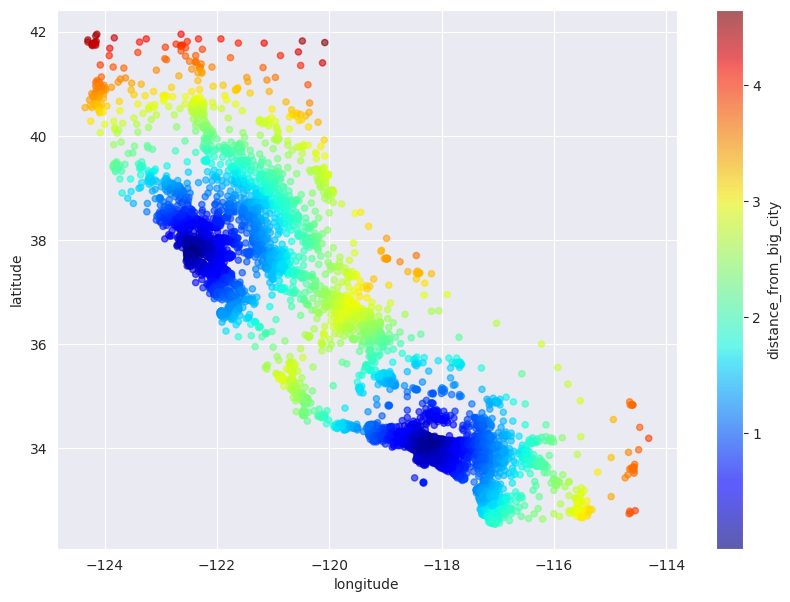

In [100]:
df_new.plot(kind="scatter", x="longitude",y="latitude", c="distance_from_big_city", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7), alpha=0.6)

Valutiamo l'utilità di questa feature calcolandone la correlazione con _median_house_value_:

-0.43845620218454623


<Axes: xlabel='distance_from_big_city', ylabel='median_house_value'>

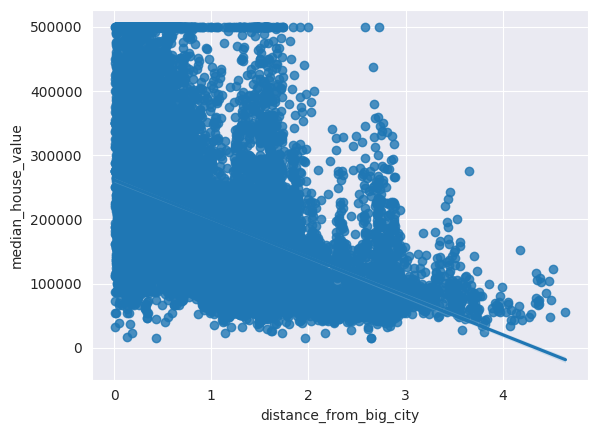

In [101]:
print(df_new['distance_from_big_city'].corr(df_new['median_house_value']))
sns.regplot(x='distance_from_big_city', y='median_house_value', data=df_new)

Si ottiene una correlazione abbastanza significativa, rispetto a quelle delle altre feature del dataset.
Valutiamo ora il modello con questa nuova feature:

In [102]:
X = df_new.drop(columns=['median_house_value'])
Y = df_new['median_house_value']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RS)
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))
results.append({"tipo":"Multipla con feature aggiunta", "n_feature":len(X.columns), "validation":"Holdout", "r2":r2_score(Y_test, y_hat), "adj_r2":adj_r2_score(Y_test, y_hat, len(X.columns))})

MSE: 4365038382.632455
Root MSE: 66068.43711359044
MAE: 48396.825730422905
R2 score 0.6705781286281463
Adj. R2 score 0.6694568287985314


In [103]:
kf = KFold(n_splits=4, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, len(X.columns))
results.append({"tipo":"Multipla con feature aggiunta", "n_feature":len(X.columns), "validation":"K-fold (n_fold=4)", "r2":r2_score(Y, y_hat), "adj_r2":adj_r2_score(Y, y_hat, len(X.columns))})

MSE: 4588096735.511419
Root MSE: 67735.4909594034
MAE: 49015.88794963137
R2 score 0.6554319626356184
Adj. R2 score 0.6551980740284378


Si ottiene un R2 score di **0.670** che è migliore di tutti gli altri risultati

# Recap dei risultati e conclusione:

In [104]:
for result in results:
    print("%-35s\t%-5i\t%-20s\t%6f\t%f" % (result['tipo'], result['n_feature'], result['validation'], result['r2'], result['adj_r2']))

Semplice                           	1    	Holdout             	0.490998	0.490875
Semplice                           	1    	K-fold (n_fold=4)   	0.473108	0.473083
Multipla con tutte le feature      	13   	Holdout             	0.658058	0.656977
Multipla con tutte le feature      	13   	K-fold (n_fold=4)   	0.644843	0.644619
Multipla con feature selection     	4    	K-fold (n_fold=4)   	0.586993	0.586912
Multipla con feature selection     	4    	Holdout             	0.601771	0.601385
Multipla con rimozione outlier     	13   	Holdout             	0.630564	0.629396
Multipla con feature aggiunta      	14   	Holdout             	0.670578	0.669457
Multipla con feature aggiunta      	14   	K-fold (n_fold=4)   	0.655432	0.655198


Il miglior risultato è stato ottenuto con una regressione lineare multipla con tutte le feature, con holdout validation e con l'aggiunta della feature _distance_from_big_city_, con un discreto miglioramento rispetto al punto di partenza. Non è un risultato eccezionale ma è comunque buono considerando che si tratta di un modello lineare.